# 8.4 Generating images with variational autoencoders

Sampling from a latent space of images to create entirely new images or edit existing ones is currently the most popular and successful application of creative AI. 

Two main techniques in this domain are: *variational autoencoders* (VAEs) and *generative adversarial networks* (GANs). These techniques aren't specific to images, but in practice the most interesting results have been obtained with pictures. 

## 8.4.1 Sampling from latent spaces of images

The central idea of *image generation* is to develop a low-dimensional *latent space* of representations where any point can be mapped to a realistic-looking image. 

The module capable of realizing this mapping is called a *generator* (for GANs) or an *autoencoder* (for VAEs). This module takes as input a latent point and outputs an image (a grid of pixels). Once such a latent space has been developed, you can sample points from it, either deliberately or at random, and, by mapping them to image space, generate images that have never been seen before.

GANs and VAEs are two different strategies for learning such latent spaces of image representations, each with its own characteristics. 

VAEs are great for learning latent spaces that are well structured. GANs generate images that can potentially be highly realistic, but the latent space they come from may not have as much structure and continuitiy. 

## 8.4.2 Concept vectors for image editing

The idea of *concept vector* was hinted when word embedding was covered in chapter 6. The idea is: given a latent space of representations, or an embedding space, certain directions in the space may encode interesting axes of variation in the original data. In a latent space of images of faces, for instance, there may be a *smile vectors*, such that if latent point `z` is the embedded representation of a certain face, the latent point `z + s` is the embedded representation of the same face, smiling. 

There are concept vectors for essentially any independent dimension of variation in image space. For face images, you may discover vectors for adding or removing sunglasses to a face, or turning a male face into a female face, and so on. 

## Variational autoencoders

They were discovered by [Kingma and Welling](https://arxiv.org/abs/1312.6114) and [Rezende, Mohamed, and Wierstra](https://arxiv.org/abs/1401.4082). They are a kind of generative model that's especially appropriate for the task of image editing via concept vectors. They are a modern take on autoencoders, that mixes ideas from deep learning with Bayesian inference. 

A *classical* image autoencoder takes an image, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the original image, via a decoder module. It’s then trained by using as target data the same images as the input images, meaning the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the code
(the output of the encoder), you can get the autoencoder to learn more-or-less interesting latent representations of the data. Most commonly, you’ll constrain the code to be low-dimensional and sparse (mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

In practice, such classical autoencoders don’t lead to particularly useful or nicely structured latent spaces. They’re not much good at compression, either. For these reasons, they have largely fallen out of fashion. VAE s, however, augment autoencoders
with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a powerful tool for image generation.

A VAE , instead of compressing its input image into a fixed code in the latent space, turns the image into the parameters of a statistical distribution: a mean and a variance. Essentially, this means you’re assuming the input image has been generated by a
statistical process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.

In technical terms, here’s how a VAE works:
1. An encoder module turns the input samples input_img into two parameters in a latent space of representations, `z_mean` and `z _ log_variance`.
2. You randomly sample a point z from the latent normal distribution that’s
assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values.
3. A decoder module maps this point in the latent space back to the original input image.

Because `epsilon` is random, the process ensures that every point that’s close to the latent loca-
tion where you encoded `input_img` (`z-mean`) can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: a *reconstruction loss* that
forces the decoded samples to match the initial inputs, and a *regularization loss* that
helps learn well-formed latent spaces and reduce overfitting to the training data. 
Let's see a Keras implementation of a VAE. It looks like this:

```python
# Encodes the input into a mean and variance parameter
z_mean, z_log_variance = encoder(input_img)
# draws a latent point using a small random epsilon
z = z_mean + exp(z_log_variance) * epsilon
# decodes z back to an image
reconstructed_img = decoder(z)
# Instantiates the autoencoder model, 
#which maps an input image to its reconstruction
model = Model(input_img, reconstructed_img)
```
You can then train the model using the aforementioned losses. 

Let's see the encoder network we'll use. It is a convnet that maps the input image `x` to two vectors, `z_mean` and `z_log_var`

### L8.23 VAE encoder network


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!pip install keras==2.0.8

     |████████████████████████████████| 276kB 2.8MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
import keras
from keras import layers
from keras import backend as K
K.clear_session()
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # dimensionality of the latent space: a 2D plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, 
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, 
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3, 
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, 
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# the input image ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Using TensorFlow backend.






Instructions for updating:
keep_dims is deprecated, use keepdims instead


Now we write the code for using `z_mean` and `z_log_var`, to generate a latent space point `z`. 

Here we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer (custom layer, used with code that is not part of a built-in layer in Keras).

### L8.24 Latent-space-sampling function

In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                            mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Now we go for the decoder implementation.  
Here we reshape the vector `z` to the dimensions of an image and then use a few convolution layers to obtain a final image output that has the same dimensions as the original `input_img`.

### L8.25 VAE decoder network, mapping latent space points to images

In [0]:
#input where we feed z
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsamples the input
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
# reshapes z into a feature map of the same shape as the feature
# mape just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu', 
                           strides=(2, 2))(x)

x = layers.Conv2D(1, 3, 
                  padding='same', 
                  activation='sigmoid')(x)

# instantiates the decoder model, which turns 'decoder_input' into the decoded image
decoder = Model(decoder_input, x)

# applies it to z to recover the decoded z
z_decoded = decoder(z)

Now for the dual loss we need to write a custom layer that internally uses the built-in `add_loss` layer method to create an arbitrary loss, since the dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`.

### L8.26 Custom ayer use to compute the VAE loss

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - 
                             K.square(z_mean) - 
                             K.exp(z_log_var), 
                             axis=-1)
    return K.mean(xent_loss + kl_loss)

  # you implement custom layers by writing a call method
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x # this is not used, but the layer has to return something

# calls the custom layer on the input and the decoded output to obtain 
# the final model output
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now we are ready to instantiate and train the model. Because the loss is taken care in the custom layer, you don't specify an external loss at compile time (`loss=None`), which in turn mean you won't pass target data during training (we only pass 
`x_train` to the model in fit).

### L8.27 Training the VAE

In [0]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, 
        shuffle=True, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(x_test, None))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_2[0][0]                   
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


10969088/11490434 [===========================>..] - ETA: 0sWARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:625: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Train on 60000 samples, validate on 10000 samples
Epoch 1/10




60000/60000 [==============================] - 64s - loss: 0.2100 - val_loss: 0.1981
Epoch 2/10
60000/60000 [==============================] - 50s - loss: 0.1923 - val_loss: 0.1897
Epoch 3/10
60000/60000 [==============================] - 49s - loss: 0.1880 - val_loss: 0.1869
Epoch 4/10
60000/60000 [==============================] - 48s - loss: 0.1854 - val_loss: 0.1841
Epoch 5/10
60000/60000 [==============================] - 48s - loss: 0.1838 - val_loss: 0.1857
Epoch 6/10
60000/60000 [===========================

Once this model is trained (on MNIST, in this case), we can use the `decoder` network to turn arbitrary latent space vectors into images.

### L8.28 Sampling a grid of points from the 2D latent space and decoding them to images

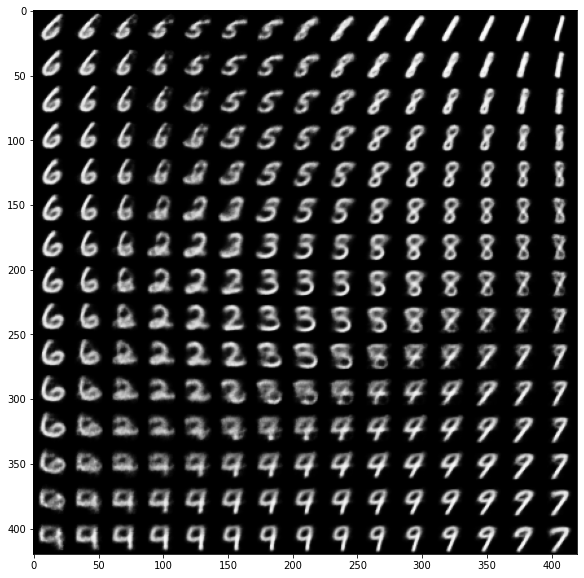

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15 # we'll display a grid of 15x15 digits (255 total)
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# transforms linearly spaced coordinates using scipy ppf funtion
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])

    # repeats z multiple times to form a complete batch
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

    # decodes the batch into digit images
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)

    # reshapes the first digit in the batch from 28x28x1 to 28x28
    digit = x_decoded[0].reshape(digit_size, digit_size)

    figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()


The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a path through latent space. Specific directions in this space have a meaning: for example, there’s a direction for “four-ness,” “one-ness,” and so on.

In [0]:
cd /content/drive/My Drive/kaggle/

/content/drive/My Drive/kaggle


In [0]:
from keras.utils import plot_model
plot_model(vae, show_shapes=True, to_file='model_vae.png')

## Wrapping up

- Image generation with deep learning is done by learning latent spaces that capture statistical information about a dataset of images. By sampling and decoding points from the latent space, you can generate never-before-seen images. There are two major tool to do this: VAEs and GANs. 
- VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of images editing in latent space: face swapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing latent-space-based animations, such as animating a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way. 
- GANs enable the generation of realistic single-frame images but may not induce latent spaces with solid structure and high continuity. 

To play further with image generation, work with the Large-scale Celeb Faces Attributes (CelebA) dataset. It’s a free-to-download image dataset containing more than 200,000 celebrity portraits. It’s great for experimenting with concept vectors in particular, it definitely beats MNIST.

